In [8]:
library(Signac)
library(Seurat)
library(rtracklayer)
library(GenomicRanges)
library(EnsDb.Mmusculus.v79)
library(viridis)
library(RColorBrewer)
library(ggplot2)
library(ggrepel)
library(UpSetR)
library(reshape2)
library(ggExtra)

source('../scripts/plotting.R')

In [11]:
# filtered snATAC output from Signac
get_filt_atac <- function() {
    load('../processing/signac/sn_filt.rda')
    obj = mb_mt_atac
    return(obj)
}

# bed files for TSSs 
get_tss_beds <- function() {
    sc_tss_10 = read.delim('../processing/ends/sc_tss_10_combo_gencode_prmenhP_cage_snatac18.bed')
    sc_tss_10_ends = read.delim('../processing/ends/sc_tss_10.sort.bed')
    return(list(sc_tss_10, sc_tss_10_ends))
}

# log2FC tables - MB vs. MT
get_mb_mt_fc_table <- function() {
    df = read.csv('../processing/ends/python_df_10pct_MBvsMT_nodupes.csv', header=T)
    return(df)
}
# log2FC tables - MB vs. MNC
get_mb_mnc_fc_table <- function() {
    df = read.csv('../processing/ends/python_df_10pct_MBvsMNC_nodupes.csv', header=T)
    return(df)
}
# log2FC tables - MNC vs. MT
get_mnc_mt_fc_table <- function() {
    df = read.csv('../processing/ends/python_df_10pct_MNCvsMT_nodupes.csv', header=T)
    return(df)
}

### Panel 4A

pdf 
  2

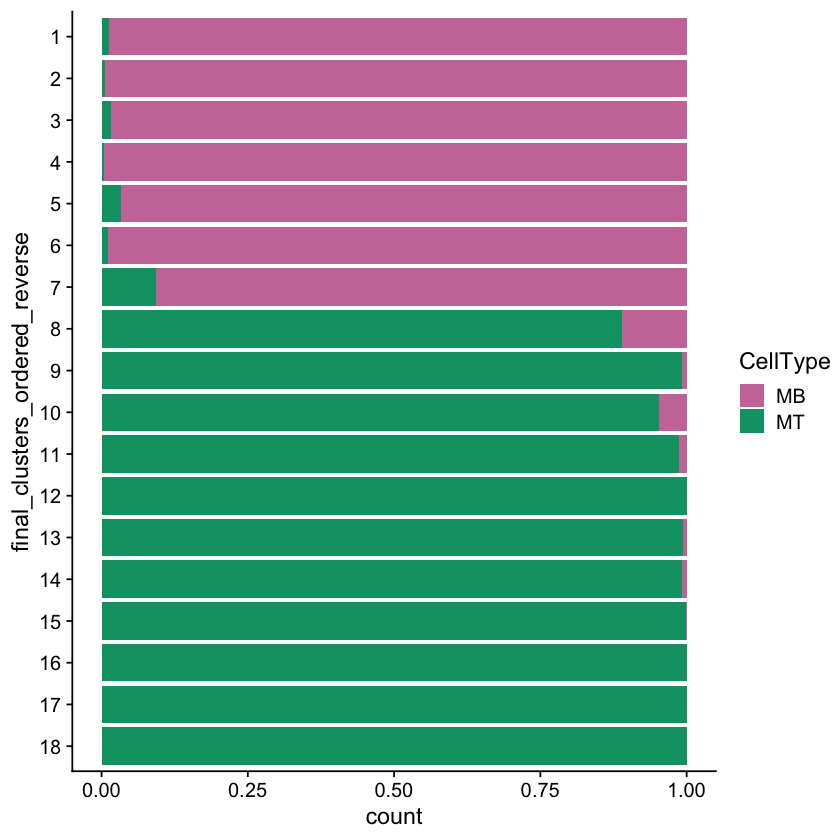

In [12]:
mb_mt_atac = get_filt_atac()
colors = get_atac_clust_colors()

fname="figures/atac_UMAP_18clusters.pdf"
pdf(file=fname,
    width=5.5,height=5)
p = DimPlot(mb_mt_atac,
        group.by = 'final_clusters_ordered',
        label = T,cols = colors,label.size = 8) + NoLegend() + NoAxes()
p
dev.off()
p

colors = get_atac_sample_colors()
pdf(file = "figures/atac_barplot.pdf",
    width = 3.2,
    height = 4.5)
p = ggplot(mb_mt_atac@meta.data, aes(x=final_clusters_ordered_reverse, fill=CellType)) + 
  geom_bar(position = "fill")  + 
  scale_fill_manual(values=colors) + 
  coord_flip()
p 
dev.off()
p

### Panel 4C

pdf 
  2

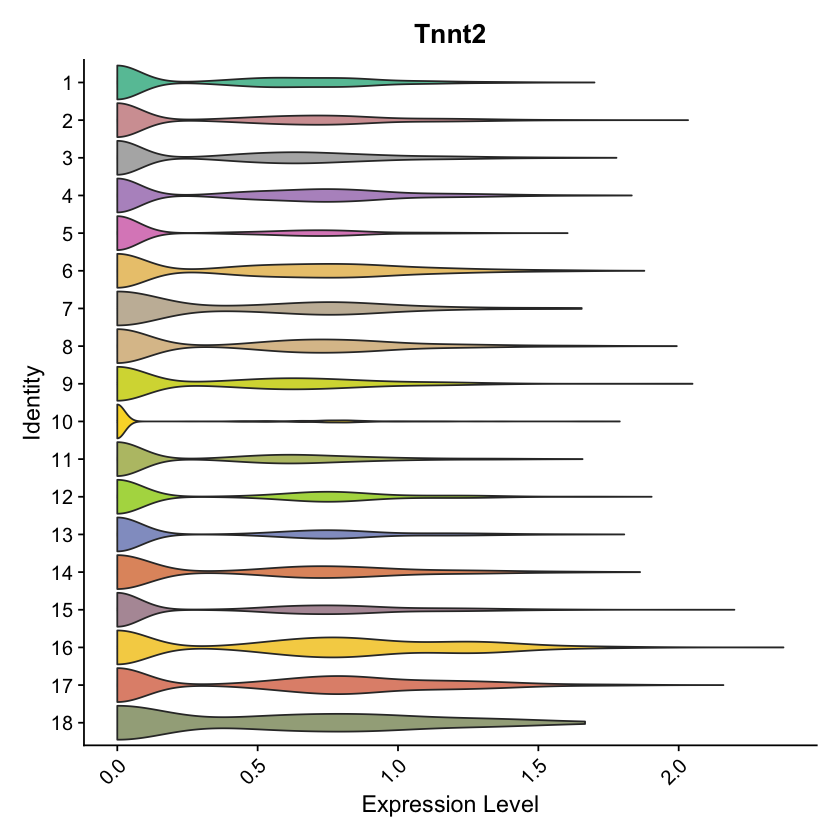

In [6]:
mb_mt_atac = get_filt_atac()
colors = get_atac_clust_colors()

fname="figures/atac_tnnt2_violin.pdf"
pdf(file=fname,
    width=3,height=11)
p = VlnPlot(mb_mt_atac,
        pt.size = 0, cols = rev(colors),
        "Tnnt2",
        assay ="RNA",
        group.by = "final_clusters_ordered_reverse") + coord_flip() + NoLegend()
p
dev.off()
p

### Panel 4C

Using combo_name as value column: use value.var to override.



pdf 
  2

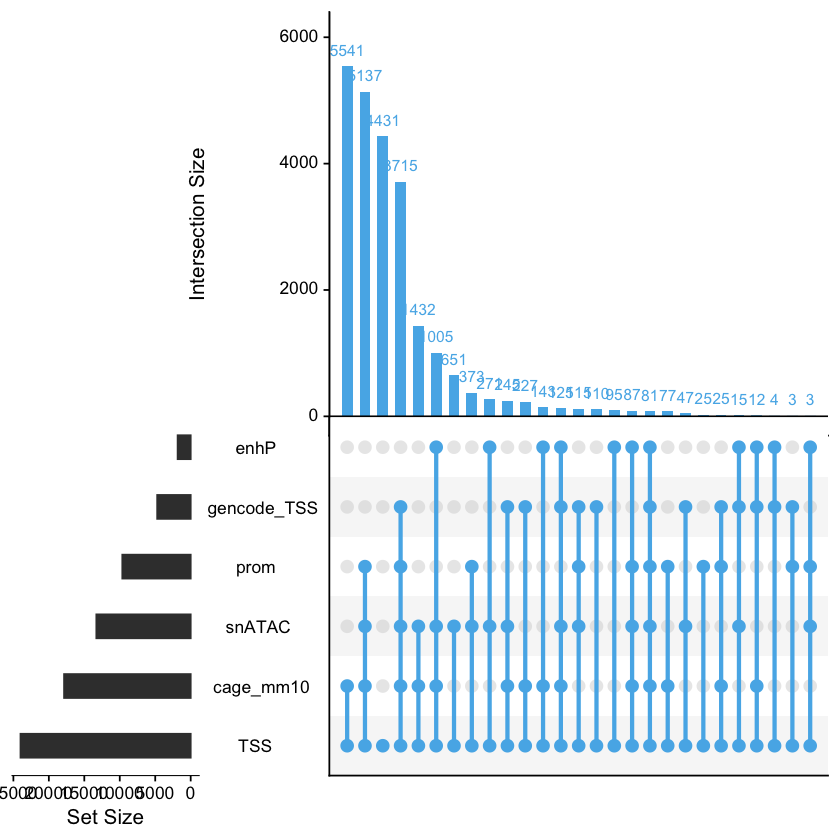

In [12]:
objs = get_tss_beds()
sc_tss_10 = objs[[1]]
sc_tss_10_ends = objs[[2]]

colnames(sc_tss_10) = c("end_chr","end_start","ends_stop","end_readID",
                        "end_score","end_strand","combo_chr","combo_start",
                        "combo_stop","combo_name","combo_score","combo_strand")
colnames(sc_tss_10_ends) = c("end_chr","end_start","ends_stop","end_readID",
                             "end_score","end_strand")

sc_tss_10$end_id_nreads = sapply(strsplit(as.character(sc_tss_10$end_readID), "ccs_"), "[[", 2)
sc_tss_10_ends$end_id_nreads = sapply(strsplit(as.character(sc_tss_10_ends$end_readID), "ccs_"), "[[", 2)

tss_missing = sc_tss_10_ends$end_id_nreads[which((sc_tss_10_ends$end_id_nreads %in% sc_tss_10$end_id_nreads) == FALSE)]
tss_missing = as.data.frame(tss_missing)
tss_missing$cage_mm10 = rep(0, length(tss_missing))
tss_missing$enhP = rep(0, dim(tss_missing)[1])
tss_missing$gencode_TSS = rep(0, dim(tss_missing)[1])
tss_missing$prom = rep(0, dim(tss_missing)[1])
tss_missing$snATAC = rep(0, dim(tss_missing)[1])

sc_tss_10_smol = sc_tss_10[,c("end_id_nreads","combo_name")]
sc_tss_10_table = dcast(sc_tss_10_smol,end_id_nreads~combo_name,fun.aggregate = function(x){as.integer(length(x) > 0)})
colnames(tss_missing) = colnames(sc_tss_10_table)
sc_tss_10_table = rbind(sc_tss_10_table, tss_missing)
sc_tss_10_table$TSS = rep(1,dim(sc_tss_10_table)[1])

fname  = "figures/sc_tss_10pct_upset.pdf"
pdf(file = fname,   
    width = 10,
    height = 4)
p = upset(
  sc_tss_10_table,
  nsets = 7,
  nintersects = NA,
  order.by = "freq",
  line.size = 1.2,
  point.size = 3.5,
  text.scale = 1.5,
  mb.ratio = c(0.5, 0.5),
  main.bar.color = "#56B4E9",
  matrix.color="#56B4E9"
)
p
dev.off()
p

### Panel 4F

pdf 
  2

Warning message:
"ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


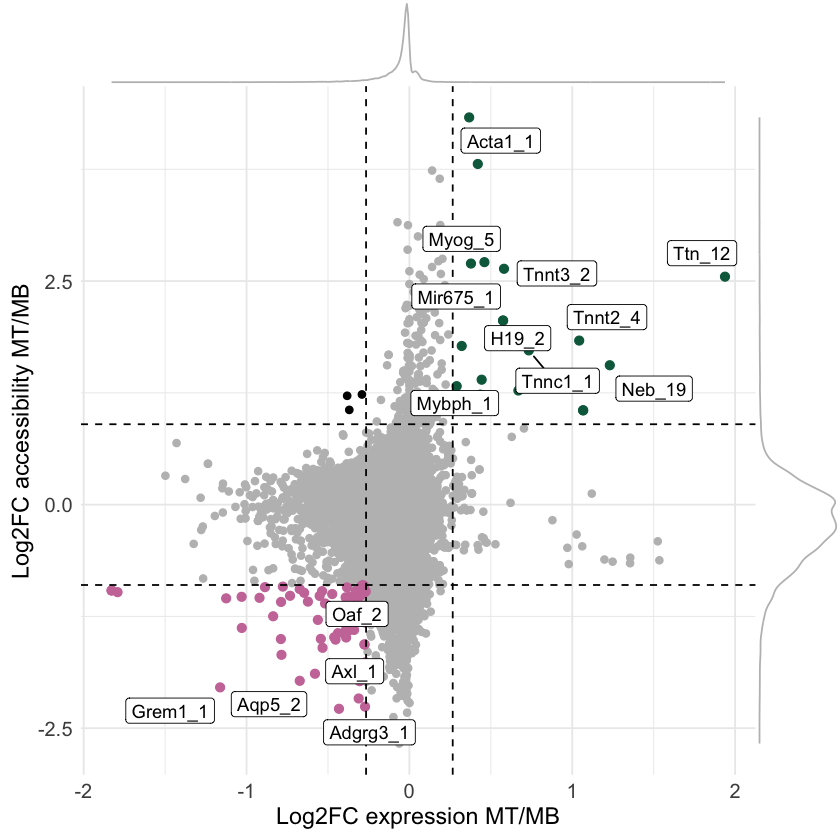

In [11]:
df = get_mb_mt_fc_table()

df = df[!(is.na(df$log2fc_tss)),]
df = df[!(is.na(df$log2fc_atac)),]

mt_both = df[df$log2fc_tss > sd((df$log2fc_tss))*2 & df$log2fc_atac > sd((df$log2fc_atac))*2,]
mt_both$marker_celltype= rep("MT",dim(mt_both)[1])
mb_both = df[df$log2fc_tss < -sd((df$log2fc_tss))*2 & df$log2fc_atac < -sd((df$log2fc_atac))*2,]
mb_both$marker_celltype= rep("MB",dim(mb_both)[1])
plot_highlight1 = rbind(mt_both,mb_both)

mt_both = df[df$log2fc_tss > sd((df$log2fc_tss))*2 & df$log2fc_atac < -sd((df$log2fc_atac))*2,]
mt_both$marker_celltype= rep("MT",dim(mt_both)[1])
mb_both = df[df$log2fc_tss < -sd((df$log2fc_tss))*2 & df$log2fc_atac > sd((df$log2fc_atac))*2,]
mb_both$marker_celltype= rep("MB",dim(mb_both)[1])
plot_highlight2 = rbind(mt_both,mb_both)

mt_both = df[df$log2fc_tss > sd((df$log2fc_tss))*3.1 & df$log2fc_atac > sd((df$log2fc_atac))*3.1,]
mt_both$marker_celltype= rep("MT",dim(mt_both)[1])
mb_both = df[df$log2fc_tss < -sd((df$log2fc_tss))*3.2 & df$log2fc_atac < -sd((df$log2fc_atac))*3.2,]
mb_both$marker_celltype= rep("MB",dim(mb_both)[1])
plot_highlight3 = rbind(mt_both,mb_both)


p = ggplot(df, aes(x=log2fc_tss, y=log2fc_atac)) +
  geom_point(fill='grey',size=1.75, color = "grey",pch=21) + theme_minimal() +
  geom_point(data=plot_highlight1,aes(x=log2fc_tss,y=log2fc_atac,color = marker_celltype),size=2.2) + 
  scale_color_manual(values = c("#cb79a7", "#08684c")) +
  geom_hline(yintercept=-sd((df$log2fc_atac))*2, linetype="dashed", color = "black") +
  geom_hline(yintercept=sd((df$log2fc_atac))*2, linetype="dashed", color = "black")+
  geom_vline(xintercept=-sd((df$log2fc_tss))*2, linetype="dashed", color = "black") +
  geom_vline(xintercept=sd((df$log2fc_tss))*2, linetype="dashed", color = "black")+
  geom_point(data=plot_highlight2,aes(x=log2fc_tss,y=log2fc_atac),color = "black",size=1.75) +
  geom_label_repel(data=plot_highlight3,
                   aes(label=gene_name),
                   box.padding = unit(0.35, "lines"),
                   point.padding = unit(0.5, "lines"),
                   force = 3) +
  theme(legend.position = "none",axis.text=element_text(size=12),
        axis.title=element_text(size=14)) + 
  xlab("Log2FC expression MT/MB") +
  ylab("Log2FC accessibility MT/MB")

fname = "figures/tss_10_mtvsmb_sectors_2SD.pdf"
pdf(file = fname,
    width = 10,
    height = 10)
p = ggMarginal(p, type = "density", margins = "both",colour = "grey",size = 8)
p
dev.off()
p

### Panel 4G

pdf 
  2

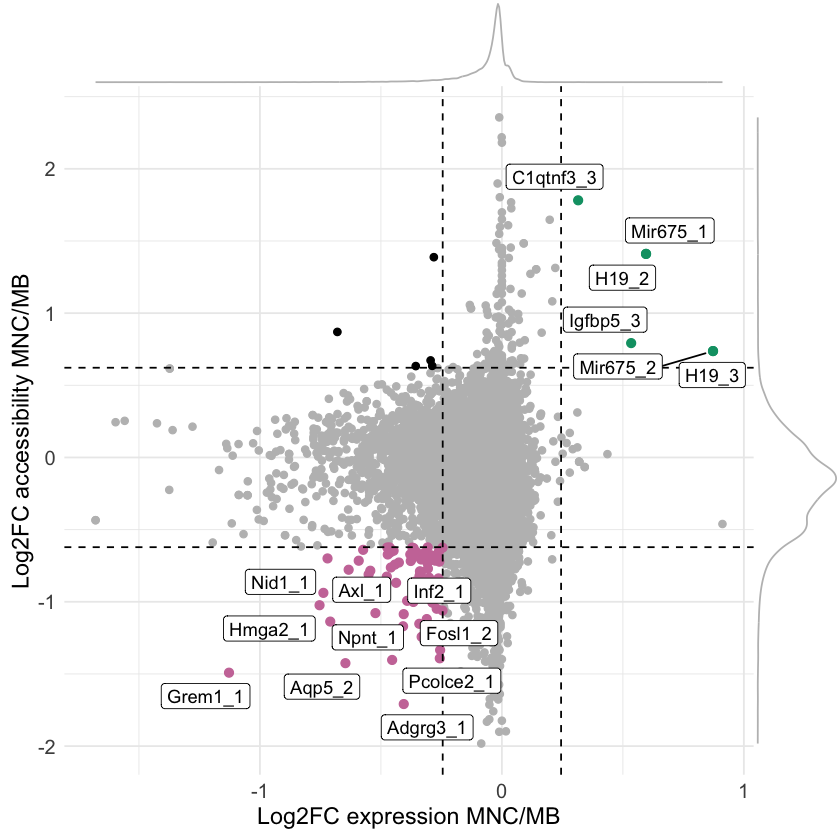

In [12]:
df = get_mb_mnc_fc_table()

df = df[!(is.na(df$log2fc_tss)),]
df = df[!(is.na(df$log2fc_atac)),]
mnc_both = df[df$log2fc_tss > sd(df$log2fc_tss)*2 & df$log2fc_atac > sd(df$log2fc_atac)*2,]
mnc_both$marker_celltype= rep("MT",dim(mnc_both)[1])
mb_both = df[df$log2fc_tss < -sd(df$log2fc_tss)*2 & df$log2fc_atac < -sd(df$log2fc_atac)*2,]
mb_both$marker_celltype= rep("MB",dim(mb_both)[1])
plot_highlight4 = rbind(mnc_both,mb_both)

mnc_both = df[df$log2fc_tss > sd(df$log2fc_tss)*2 & df$log2fc_atac < -sd(df$log2fc_atac)*2,]
mnc_both$marker_celltype= rep("MT",dim(mnc_both)[1])
mb_both = df[df$log2fc_tss < -sd(df$log2fc_tss)*2 & df$log2fc_atac > sd(df$log2fc_atac)*2,]
mb_both$marker_celltype= rep("MB",dim(mb_both)[1])
plot_highlight5 = rbind(mnc_both,mb_both)

mnc_both = df[df$log2fc_tss > sd(df$log2fc_tss)*2 & df$log2fc_atac > sd(df$log2fc_atac)*2,]
mnc_both$marker_celltype= rep("MT",dim(mnc_both)[1])
mb_both = df[df$log2fc_tss < -sd(df$log2fc_tss)*3.2 & df$log2fc_atac < -sd(df$log2fc_atac)*3.2,]
mb_both$marker_celltype= rep("MB",dim(mb_both)[1])
plot_highlight6 = rbind(mnc_both,mb_both)

p = ggplot(df, aes(x=log2fc_tss, y=log2fc_atac)) +
  geom_point(fill='grey',size=1.75, color = "grey",pch=21) + theme_minimal() +
  geom_point(data=plot_highlight4,aes(x=log2fc_tss,y=log2fc_atac,color = marker_celltype),size=2.2) + 
  scale_color_manual(values = c("#cb79a7", "#019f73")) +
  geom_hline(yintercept=-sd((df$log2fc_atac))*2, linetype="dashed", color = "black") +
  geom_hline(yintercept=sd((df$log2fc_atac))*2, linetype="dashed", color = "black")+
  geom_vline(xintercept=-sd((df$log2fc_tss))*2, linetype="dashed", color = "black") +
  geom_vline(xintercept=sd((df$log2fc_tss))*2, linetype="dashed", color = "black")+
  geom_point(data=plot_highlight5,aes(x=log2fc_tss,y=log2fc_atac),color = "black",size=1.75) +
  geom_label_repel(data=plot_highlight6,
                   aes(label=gene_name),
                   box.padding = unit(0.35, "lines"),
                   point.padding = unit(0.5, "lines"),
                   force = 3) +
  theme(legend.position = "none",axis.text=element_text(size=12),
        axis.title=element_text(size=14)) + 
  xlab("Log2FC expression MNC/MB") + 
  ylab("Log2FC accessibility MNC/MB")

fname = "figures/tss_10_mncvsmb_sectors_2SD.pdf"
pdf(file = fname,
    width =10,
    height = 10)
p = ggMarginal(p, type = "density", margins = "both",colour = "grey",size = 8)
p
dev.off()
p

### Panel 4H

Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


pdf 
  2

Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


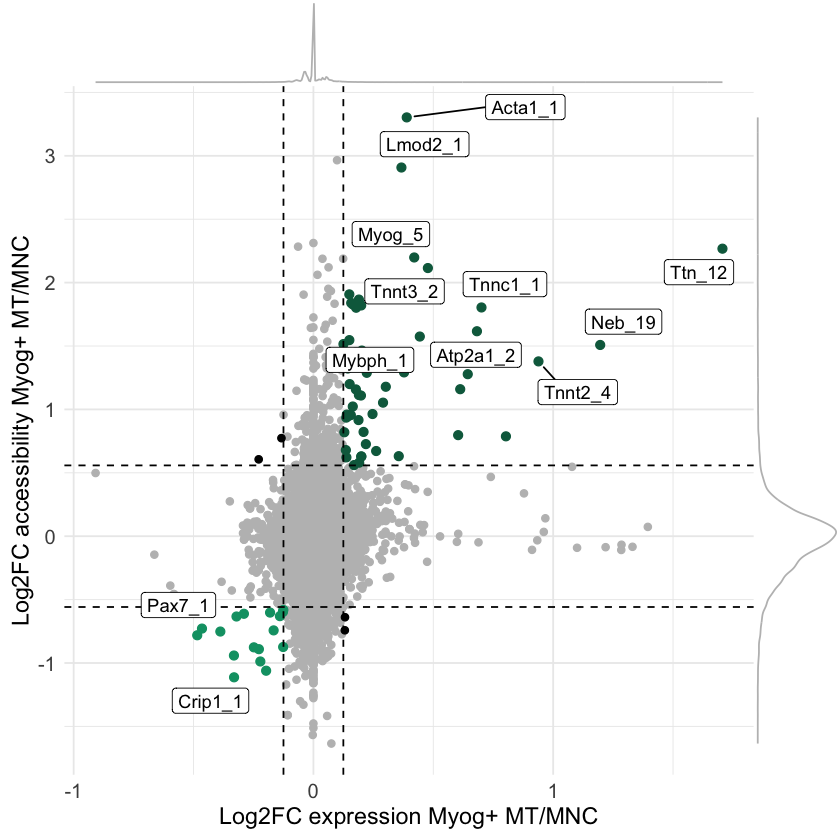

In [13]:
df = get_mnc_mt_fc_table()

df = df[!(is.na(df$log2fc_tss)),]
df = df[!(is.na(df$log2fc_atac)),]
mt_both = df[df$log2fc_tss > sd(df$log2fc_tss)*2 & df$log2fc_atac > sd(df$log2fc_atac)*2,]
mt_both$marker_celltype= rep("MT",dim(mt_both)[1])
mnc_both = df[df$log2fc_tss < -sd(df$log2fc_tss)*2 & df$log2fc_atac < -sd(df$log2fc_atac)*2,]
mnc_both$marker_celltype= rep("MB",dim(mnc_both)[1])
plot_highlight7 = rbind(mt_both,mnc_both)

mt_both = df[df$log2fc_tss > sd(df$log2fc_tss)*2 & df$log2fc_atac < -sd(df$log2fc_atac)*2,]
mt_both$marker_celltype= rep("MT",dim(mt_both)[1])
mnc_both = df[df$log2fc_tss < -sd(df$log2fc_tss)*2 & df$log2fc_atac > sd(df$log2fc_atac)*2,]
mnc_both$marker_celltype= rep("MB",dim(mnc_both)[1])
plot_highlight8 = rbind(mt_both,mnc_both)

mt_both = df[df$log2fc_tss > sd(df$log2fc_tss)*4.7 & df$log2fc_atac > sd(df$log2fc_atac)*4.7,]
mt_both$marker_celltype= rep("MT",dim(mt_both)[1])
mnc_both = df[df$log2fc_tss < -sd(df$log2fc_tss)*2.5 & df$log2fc_atac < -sd(df$log2fc_atac)*2.5,]
mnc_both$marker_celltype= rep("MB",dim(mnc_both)[1])
plot_highlight9 = rbind(mt_both,mnc_both)

p = ggplot(df, aes(x=log2fc_tss, y=log2fc_atac)) +
  geom_point(fill='grey',size=1.75, color = "grey",pch=21) + theme_minimal() +
  geom_point(data=plot_highlight7,aes(x=log2fc_tss,y=log2fc_atac,color = marker_celltype),size=2.2) + 
  scale_color_manual(values = c("#019f73", "#08684c")) +
  geom_hline(yintercept=-sd(df$log2fc_atac)*2, linetype="dashed", color = "black") +
  geom_hline(yintercept=sd(df$log2fc_atac)*2, linetype="dashed", color = "black")+
  geom_vline(xintercept=-sd(df$log2fc_tss)*2, linetype="dashed", color = "black") +
  geom_vline(xintercept=sd(df$log2fc_tss)*2, linetype="dashed", color = "black")+
  geom_point(data=plot_highlight8,aes(x=log2fc_tss,y=log2fc_atac),color = "black",size=1.75) +
  geom_label_repel(data=plot_highlight9,
                   aes(label=gene_name),
                   box.padding = unit(0.35, "lines"),
                   point.padding = unit(0.5, "lines"),
                   force = 3) +
  theme(legend.position = "none",axis.text=element_text(size=12),
        axis.title=element_text(size=14)) + 
  xlab("Log2FC expression Myog+ MT/MNC") + 
  ylab("Log2FC accessibility Myog+ MT/MNC")

fname = "figures/tss_10_mtvsmnc_sectors_2SD.pdf"
pdf(file = fname,
    width = 10,
    height = 10)
p = ggMarginal(p, type = "density", margins = "both",colour = "grey",size = 8)
p
dev.off()
p